In [8]:
from datasets import load_dataset

fiqa_eval = load_dataset("explodinggradients/fiqa", "ragas_eval")
fiqa_eval

DatasetDict({
    baseline: Dataset({
        features: ['question', 'ground_truths', 'answer', 'contexts'],
        num_rows: 30
    })
})

In [9]:
from ragas.metrics import (
    context_relevancy,
    context_precision,
    context_recall,
    faithfulness,
    answer_relevancy,
)

In [10]:
# LangChain supports many other chat models. Here, we're using Ollama
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

# supports many more optional parameters. Hover on your `ChatOllama(...)`
# class to view the latest available supported parameters
llm = ChatOllama(model="mistral")
prompt = ChatPromptTemplate.from_template("Tell me a short joke about {topic}")

# using LangChain Expressive Language chain syntax
# learn more about the LCEL on
# /docs/concepts/#langchain-expression-language-lcel
chain = prompt | llm | StrOutputParser()

# for brevity, response is printed in terminal
# You can use LangServe to deploy your application for
# production
print(chain.invoke({"topic": "Space travel"}))

 Why don't ET's call Martians when they need help?

Because they're in an intergalactic calling plan with Neptune! (A play on words: "intergalactic" means "between galaxies," and "Neptune" is a planet far from Earth.)


In [11]:
from ragas.llms import LangchainLLMWrapper

mistral_wrapper = LangchainLLMWrapper(langchain_llm=llm)
faithfulness.llm = mistral_wrapper
context_precision.llm = mistral_wrapper
answer_relevancy.llm = mistral_wrapper
context_recall.llm = mistral_wrapper
context_relevancy.llm = mistral_wrapper

In [13]:
# evaluate
from ragas import evaluate
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
fast_embeddings = FastEmbedEmbeddings(model_name="BAAI/bge-base-en")

result = evaluate(
    fiqa_eval["baseline"].select(range(3)),  # showing only 3 for demonstration
     metrics=[
        context_precision,
        faithfulness,
        context_recall,
        answer_relevancy,
        context_relevancy
    ],
    embeddings=fast_embeddings
)

result

100%|██████████| 252M/252M [00:14<00:00, 18.0MiB/s] 
passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`


Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
df = result.to_pandas()
df.head()

,question,ground_truths,answer,contexts,ground_truth,context_precision,faithfulness,context_recall
0,How to deposit a cheque issued to an associate...,[Have the check reissued to the proper payee.J...,\nThe best way to deposit a cheque issued to a...,[Just have the associate sign the back and the...,Have the check reissued to the proper payee.Ju...,1.0,1.0,0.75
1,Can I send a money order from USPS as a business?,[Sure you can. You can fill in whatever you w...,"\nYes, you can send a money order from USPS as...",[Sure you can. You can fill in whatever you w...,Sure you can. You can fill in whatever you wa...,1.0,1.0,1.00
2,1 EIN doing business under multiple business n...,[You're confusing a lot of things here. Compan...,"\nYes, it is possible to have one EIN doing bu...",[You're confusing a lot of things here. Compan...,You're confusing a lot of things here. Company...,1.0,0.0,1.00


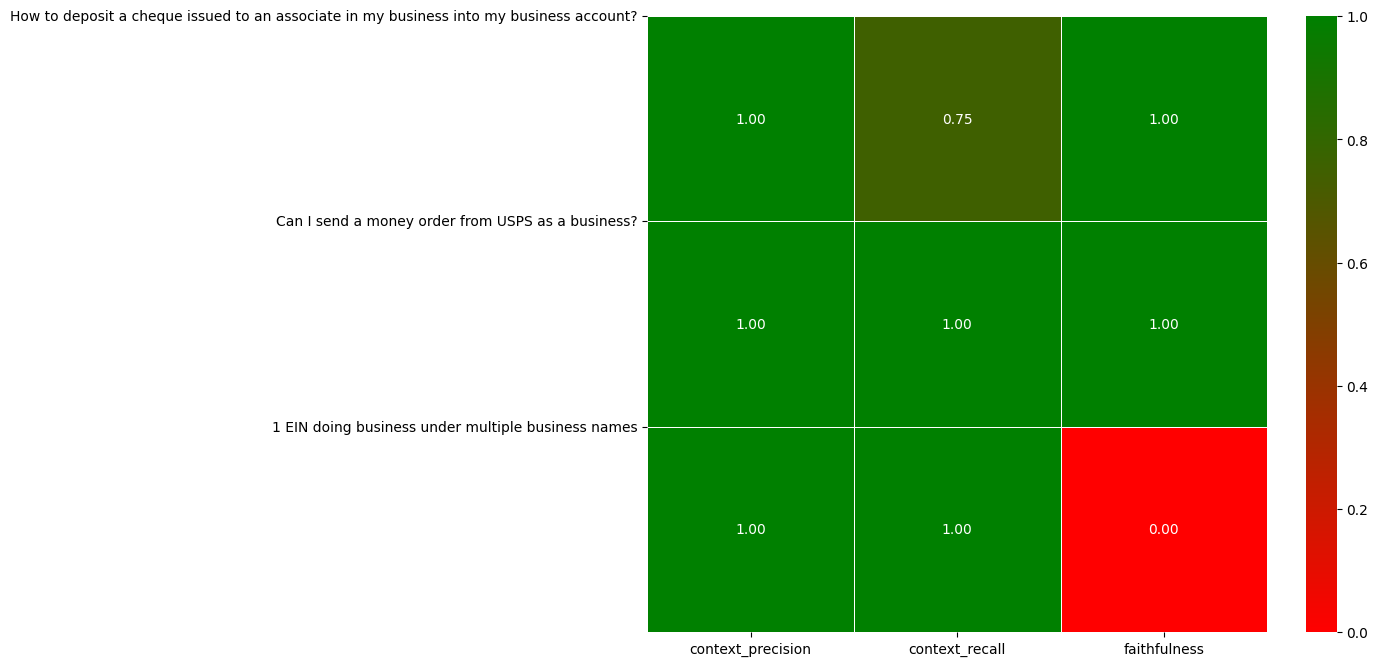

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


heatmap_data = df[['context_precision', 'context_recall', 'faithfulness']]

cmap = LinearSegmentedColormap.from_list('green_red', ['red', 'green'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)

plt.yticks(ticks=range(len(df['question'])), labels=df['question'], rotation=0)

plt.show()